In [1]:
import os
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
#!pip install opencv-python
import cv2
import sys
import pickle

#!pip install git+https://github.com/facebookresearch/segment-anything.git

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import os

In [2]:
sam_checkpoint = "../data/SAM_checkpoint/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"
sam_model = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [3]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [4]:
colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
for i in range(len(colors)):
    h = colors[i].lstrip('#')
    colors[i] = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
print(colors)

[(230, 25, 75), (60, 180, 75), (255, 225, 25), (67, 99, 216), (245, 130, 49), (145, 30, 180), (70, 240, 240), (240, 50, 230), (188, 246, 12), (250, 190, 190), (0, 128, 128), (230, 190, 255), (154, 99, 36), (255, 250, 200), (128, 0, 0), (170, 255, 195), (128, 128, 0), (255, 216, 177), (0, 0, 117), (128, 128, 128)]


In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for cl, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:, :, i] = colors[cl][i] / 255
        ax.imshow(np.dstack((img, m * 0.35)))

In [6]:
def transform_image(img):
    image = np.expand_dims(img, axis=2)
    image = np.repeat(255 - image, 3, axis=2)
    return image

In [7]:
img = sp.io.loadmat("../data/Kaggle/Farsiu_Ophthalmology_2013_AMD_Subject_1001.mat")

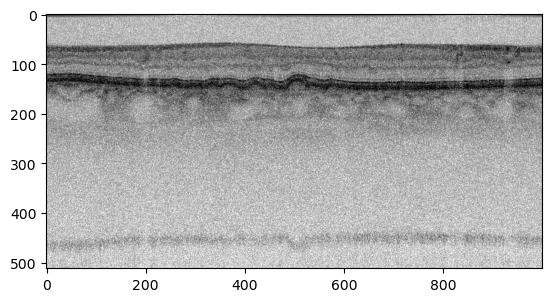

In [8]:
plt.imshow(transform_image(img['images'][:, :, 41]))
plt.show()

1


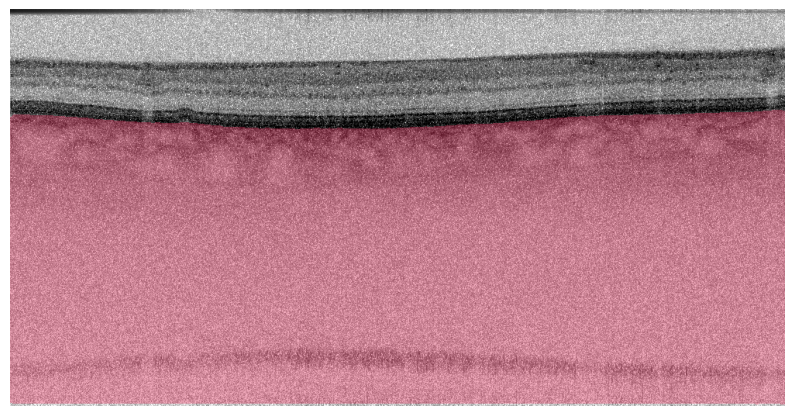

In [9]:
masks = mask_generator_.generate(transform_image(img['images'][:, :, 25]))
print(len(masks))
plt.figure(figsize=(10, 10))
plt.imshow(transform_image(img['images'][:, :, 25]))
show_anns(masks)
plt.axis('off')
plt.show()

In [28]:
masks = mask_generator_.generate(transform_image(img['images'][:, :, 25]))
print(len(masks))
plt.figure(figsize=(10, 10))
plt.imshow(transform_image(img['images'][:, :, 25]))
show_anns(masks)
plt.axis('off')
plt.show()

IndexError: too many indices for tensor of dimension 1

In [27]:
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam_model,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.96,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [65]:
sam_model.load_state_dict(torch.load("../data/Kaggle/model_checkpoints/chkpt1.pt"))

<All keys matched successfully>

In [66]:
sam_model_orig = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam_model_orig.to(device);

In [67]:
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [68]:
predictor_tuned.set_image(transform_image(img['images'][:, :, 25]))
predictor_original.set_image(transform_image(img['images'][:, :, 25]))


In [69]:
with open("..\data\Kaggle\preprocessed\\amd_"+"001"+".pkl", 'rb') as file:
    dict = pickle.load(file)

In [70]:
bbox = dict['images'][25]['bbox'][1]

In [71]:
bbox

array([ 56., 307., 150., 811.])

In [72]:

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=bbox,
    multimask_output=False,
)

In [73]:
masks_orig

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

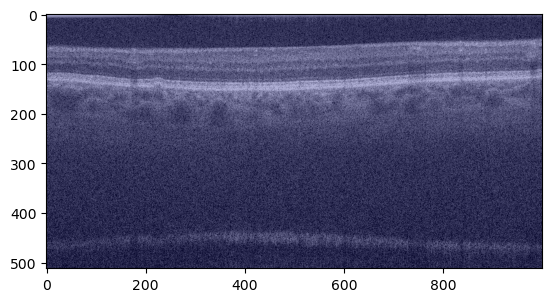

In [74]:
plt.imshow(img['images'][:, :, 25], cmap='gray')
plt.imshow(np.squeeze(masks_tuned), cmap='jet', alpha=0.3)

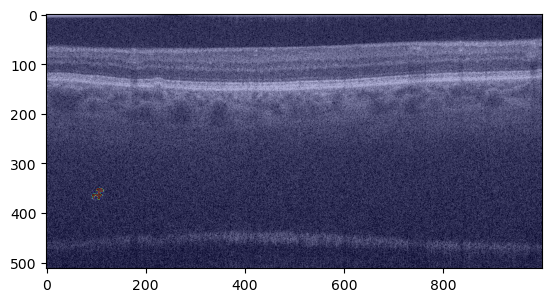

In [75]:
plt.imshow(img['images'][:, :, 25], cmap='gray')
plt.imshow(np.squeeze(masks_orig), cmap='jet', alpha=0.3)